In [1]:
import IPython
#install requirements if needed
from IPython.display import clear_output
!pip install --upgrade pip
!pip install --upgrade pandas
!pip install --upgrade numpy
!pip install statsmodels
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn
clear_output()

In [2]:
#Importing Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
%matplotlib inline
pd.plotting.register_matplotlib_converters()
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
nome_arquivo = 'series.csv'

In [4]:
def ler_df(nome,p=True,idf=True):
    df = pd.read_csv(nome, parse_dates=p ,infer_datetime_format=idf)
    df['DATE'] = pd.to_datetime(df['DATE'])
    df.set_index(pd.DatetimeIndex(df['DATE']), inplace=True)    
    df = df.sort_index()
    print(df.info())
    return df

In [5]:
def separa_categoria(df):
    output_dfs = []
    idx = pd.date_range('2018-09-24', '2021-11-12')
    for category in df['CATEGORY'].unique():
        df_out = df[df['CATEGORY'] == category][['UNITS_SOLD']]
        df_out = df_out[df_out.index > '2019-06-12']
        df_out = df_out.reindex(idx, fill_value=0)
        output = {'Category': category, 'DataFrame':df_out}
        output_dfs.append(output)
    return output_dfs

In [6]:
def arima_model_meli(df,steps=21):
    '''Função para criar os testes estatísticos, validação e modelagem'''
    print(" \n \n ########################### Iniciando Model - Categoria: " + df['Category']+ " ######################################### \n \n")
    X=df['DataFrame'].values
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    
    # Aplicação de um teste de estacionariedade ADFULLER para verificação da necessidade de aplicar
    # diferença na séries temporal:
    # 1 - Estatística do teste + p-valor;
    # 2 - Estatística do teste + p-valor da primeira diferença;
    print(" \n Teste ADF para validação de estacionaridade, buscamos p<= 0.5 \n")
    p = adfuller(df['DataFrame']['UNITS_SOLD'])[1]
    plt.plot(df['DataFrame']['UNITS_SOLD'])
    plt.show()
    print('ADF p-value: {}'.format(p))
    p_dif = adfuller(df['DataFrame']['UNITS_SOLD'].diff().dropna())[1]
    plt.plot(df['DataFrame']['UNITS_SOLD'].diff().dropna())
    plt.show()
    print('ADF p-value: {}'.format(p_dif))
    
    
    # A partir dos valores-p calculados, determina-se o d do modelo
    # ARIMAX: d, stat.
    if p_dif <= 0.05:
        dzin = 1
        stat = True

    else:
        dzin = 0
        stat = False
        
    print('Valor escolhido d: {}'.format(dzin))

    # A definição do restante dos parâmetros do modelo ARIMA vou fazer de forma iterativa
    # São testadas as combinações dos valores 0, 1, 2 e aquela com menor erro no dataset de teste
    flag = 0
    d = dzin
    for p in range(3):
        for q in range(3):
            try:
                model_arima = ARIMA(train, order = (p, d, q), enforce_stationarity=stat)
                model_fit = model_arima.fit()
                test_fit = model_fit.forecast(steps=len(test))        
                
                erro = sqrt(mean_squared_error(test, test_fit))
                print('Combinação ({}, {}, {}) - Erro: {}'.format(p, d, q, erro))
                
                if flag == 1:
                    if erro < erro_bck:
                        erro_bck = erro
                        p_bck = p
                        d_bck = d
                        q_bck = q
                        test_fit_bck = test_fit
                if flag == 0:
                    flag = 1
                    erro_bck = erro
                    p_bck = p
                    d_bck = d
                    q_bck = q
                    test_fit = model_fit.forecast(steps=len(test))
            except Exception as e: 
                print(e)
                pass

    print('best model: (p, d, q):(', p_bck, d_bck, q_bck, ')','Test RMSE: %.3f' % erro_bck)
    
    # Treinamento do modelo completo (treino+teste)
    model_arima = ARIMA(X,
                            order = (p_bck, d_bck, q_bck),
                            enforce_stationarity=stat)

    model_fit = model_arima.fit()
    #Previsão dos x dias escolhidos na função
    predict = model_fit.forecast(steps=steps)
    plt.plot(X)
    plt.plot(range(len(X),len(X)+steps),predict)
    plt.show()
    print("######### Valores para os próximos 21 dias #########")
    print("\n")
    print(predict)
    #Em um modelo produtivo poderiamos retornar aqui qual os resultados, quais parametros utilizados para um futuro tunnig
    return print(" \n \n ########################### Modelo finalizado ######################################### \n \n")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2686 entries, 2018-09-24 to 2021-11-12
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CATEGORY    2686 non-null   object        
 1   DATE        2686 non-null   datetime64[ns]
 2   UNITS_SOLD  2686 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 83.9+ KB
None
 
 
 ########################### Iniciando Model - Categoria: CATEG-3 ######################################### 
 

 
 Teste ADF para validação de estacionaridade, buscamos p<= 0.5 



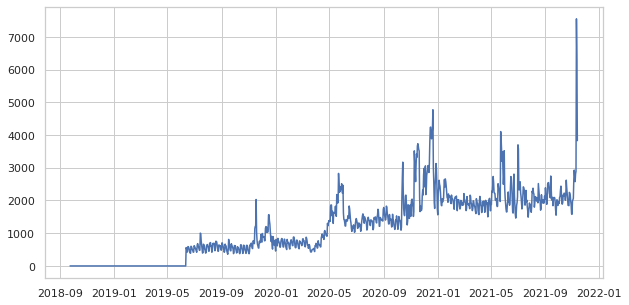

ADF p-value: 0.8099755647348933


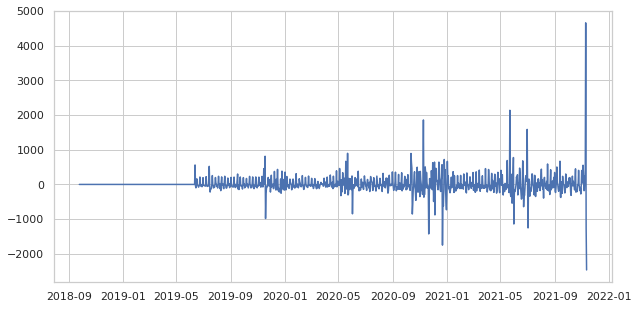

ADF p-value: 2.479316524260084e-14
Valor escolhido d: 1
Combinação (0, 1, 0) - Erro: 932.4684568804047
Combinação (0, 1, 1) - Erro: 934.9331880554281
Combinação (0, 1, 2) - Erro: 797.6405507340128
Combinação (1, 1, 0) - Erro: 934.282913618716
Combinação (1, 1, 1) - Erro: 847.2862783964049


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Combinação (1, 1, 2) - Erro: 795.626975043357
Combinação (2, 1, 0) - Erro: 908.2403027019157
Combinação (2, 1, 1) - Erro: 765.2745305549331


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Combinação (2, 1, 2) - Erro: 815.6651104148182
best model: (p, d, q):( 2 1 1 ) Test RMSE: 765.275


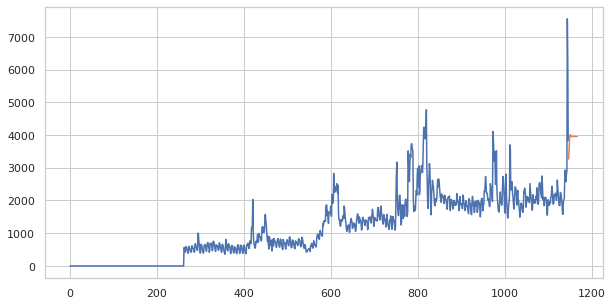

######### Valores para os próximos 21 dias #########


[3268.22960851 3529.32850745 3848.61834308 3994.74351465 4010.0633066
 3982.60103801 3960.28475976 3952.4489256  3952.96784014 3955.33678042
 3956.78691598 3957.14529498 3957.01073887 3956.82828931 3956.74101185
 3956.72973142 3956.74470963 3956.75763589 3956.76241429 3956.76227398
 3956.76094713]
 
 
 ########################### Modelo finalizado ######################################### 
 

 
 
 ########################### Iniciando Model - Categoria: CATEG-1 ######################################### 
 

 
 Teste ADF para validação de estacionaridade, buscamos p<= 0.5 



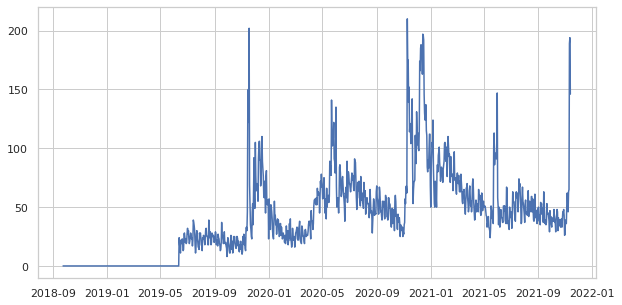

ADF p-value: 0.2128552016863452


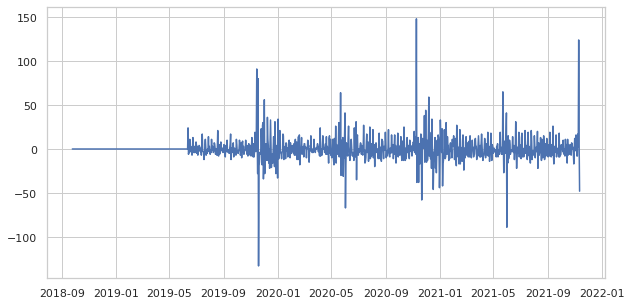

ADF p-value: 3.0777617290918717e-16
Valor escolhido d: 1
Combinação (0, 1, 0) - Erro: 49.26615314953915
Combinação (0, 1, 1) - Erro: 48.19328663890528
Combinação (0, 1, 2) - Erro: 45.11924361777738
Combinação (1, 1, 0) - Erro: 49.13966176881389
Combinação (1, 1, 1) - Erro: 42.882315158887465
Combinação (1, 1, 2) - Erro: 42.83860742565868
Combinação (2, 1, 0) - Erro: 48.082729242520124
Combinação (2, 1, 1) - Erro: 42.84694080067275
Combinação (2, 1, 2) - Erro: 42.85158186381452
best model: (p, d, q):( 1 1 2 ) Test RMSE: 42.839


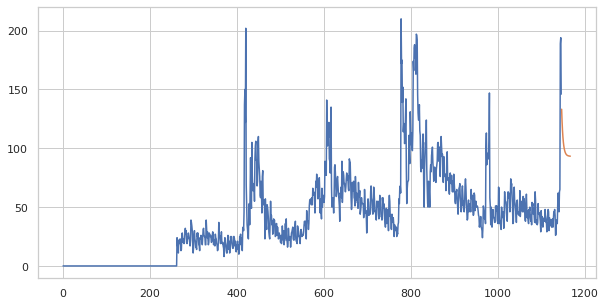

######### Valores para os próximos 21 dias #########


[133.19387028 122.72784609 115.00132704 109.29724156 105.08621316
 101.97743082  99.68237918  97.98806242  96.73723684  95.81381765
  95.13210548  94.62883299  94.2572932   93.98300478  93.78051196
  93.63102209  93.52066152  93.43918808  93.37904049  93.33463667
  93.30185565]
 
 
 ########################### Modelo finalizado ######################################### 
 

 
 
 ########################### Iniciando Model - Categoria: CATEG-2 ######################################### 
 

 
 Teste ADF para validação de estacionaridade, buscamos p<= 0.5 



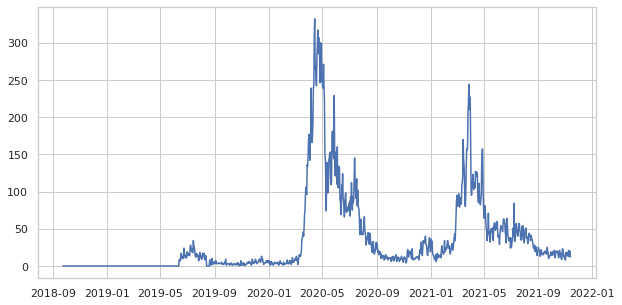

ADF p-value: 0.01059707306352086


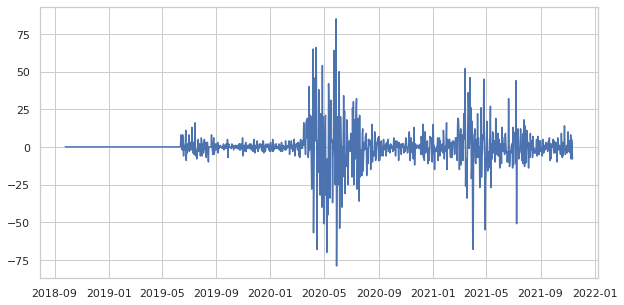

ADF p-value: 1.2674731821607225e-08
Valor escolhido d: 1
Combinação (0, 1, 0) - Erro: 51.854901110992095
Combinação (0, 1, 1) - Erro: 52.01831315605772
Combinação (0, 1, 2) - Erro: 52.03812656777681
Combinação (1, 1, 0) - Erro: 51.941042462927435
Combinação (1, 1, 1) - Erro: 51.92520598088553
Combinação (1, 1, 2) - Erro: 51.948436124857835
Combinação (2, 1, 0) - Erro: 52.138947457637435
Combinação (2, 1, 1) - Erro: 51.95780073718143


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Combinação (2, 1, 2) - Erro: 51.997024351726466
best model: (p, d, q):( 0 1 0 ) Test RMSE: 51.855


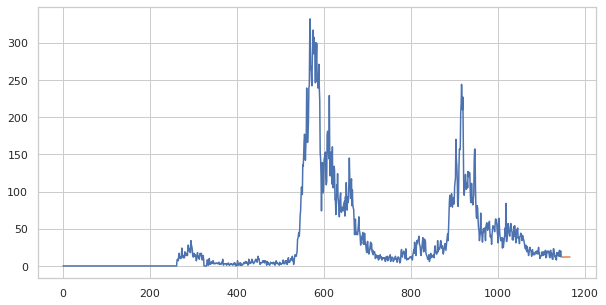

######### Valores para os próximos 21 dias #########


[12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
 12. 12. 12.]
 
 
 ########################### Modelo finalizado ######################################### 
 



In [7]:
df = ler_df(nome_arquivo)
dfs_separados = separa_categoria(df)
for df_modelo in dfs_separados:
    arima_model_meli(df_modelo)

# Próximos passos:
## Os modelos não ficaram tão bons, precisaríamos fazer um teste com o SARIMA para tentar agregar o fator de sasonalidade
## Há alguns metodos mais modernos como LSTM para tentar prever com maior precisão esses valores, sendo que a rede neural conseguiria receber mais varíaveis como dia da semana, mes, dia do mes, feriados e etc para prever a sasonalidade